### 이미지마다 중점 부위 x, y 좌표 맵핑

In [4]:
import pandas as pd

# 1. CSV 로딩
df = pd.read_csv("./coords_rsna_improved.csv")

# 2. 좌표 변환
IMG_SIZE = 256
df["x"] = (df["relative_x"] * IMG_SIZE).astype(int)
df["y"] = (df["relative_y"] * IMG_SIZE).astype(int)

# 3. level 정렬
level_order = ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']
df["level"] = pd.Categorical(df["level"], categories=level_order, ordered=True)
df = df.sort_values(by=["series_id", "level"])

# 4. 그룹 필터링: 5개 레벨이 모두 있는 series_id만 사용
valid_series = df.groupby("series_id")["level"].count()
valid_series = valid_series[valid_series == 5].index
df = df[df["series_id"].isin(valid_series)]

# 5. wide format 변환
def extract_coords(x):
    return pd.Series({
        "x1": x.iloc[0]["x"], "y1": x.iloc[0]["y"],
        "x2": x.iloc[1]["x"], "y2": x.iloc[1]["y"],
        "x3": x.iloc[2]["x"], "y3": x.iloc[2]["y"],
        "x4": x.iloc[3]["x"], "y4": x.iloc[3]["y"],
        "x5": x.iloc[4]["x"], "y5": x.iloc[4]["y"]
    })

coords_df = df.groupby("series_id").apply(extract_coords).reset_index()

# 6. 파일명/라벨 추가
coords_df["filename"] = coords_df["series_id"].astype(str) + ".jpg"
coords_df["label"] = 0  # 기본 라벨 (나중에 수정 가능)

# 7. 저장
coords_df.to_csv("./mydata/coords_processed.csv", index=False)

C:\Users\human-12\AppData\Local\Temp\ipykernel_6864\1675292458.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  coords_df = df.groupby("series_id").apply(extract_coords).reset_index()


In [6]:
from dataset import DiskCropDataset
from torchvision import transforms

# 전처리 정의 (예시)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Dataset 인스턴스 생성
dataset = DiskCropDataset(
    image_dir="./data/processed_lsd_jpgs",
    coord_csv_path="./mydata/coords_processed.csv",
    transform=transform,
    crop_size=64
)

# 예시 출력
crops, label = dataset[0]
print(crops.shape)  # → torch.Size([5, 1, 64, 64])
print(label)        # → 0 또는 1

FileNotFoundError: [Errno 2] No such file or directory: './data/processed_lsd_jpgs\\21449862.jpg'

### 이미지데이터 파일명 동일한지 비교 확인

In [7]:
import os
print(sorted(os.listdir("./data/processed_lsd_jpgs"))[:5])

['0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg']


In [8]:
import pandas as pd
df = pd.read_csv("./mydata/coords_processed.csv")
print(df["filename"].head())

0    21449862.jpg
1    28677612.jpg
2    33997481.jpg
3    40818364.jpg
4    46153672.jpg
Name: filename, dtype: object


### 이미지 파일명을 csv의 칼럼에 맞게 rename

In [9]:
import os
import shutil
import pandas as pd

src_dir = "./data/processed_lsd_jpgs"
dst_dir = "./data/processed_lsd_jpgs_renamed"
os.makedirs(dst_dir, exist_ok=True)

# 실제 .csv에 있는 파일명 순서대로 rename
df = pd.read_csv("./mydata/coords_processed.csv")
csv_filenames = df["filename"].tolist()
img_files = sorted(os.listdir(src_dir))

assert len(img_files) >= len(csv_filenames), "이미지 수 부족!"

for src_file, new_name in zip(img_files, csv_filenames):
    src_path = os.path.join(src_dir, src_file)
    dst_path = os.path.join(dst_dir, new_name)
    shutil.copy(src_path, dst_path)

print("이미지 파일명 재정렬 완료 →", dst_dir)

이미지 파일명 재정렬 완료 → ./data/processed_lsd_jpgs_renamed


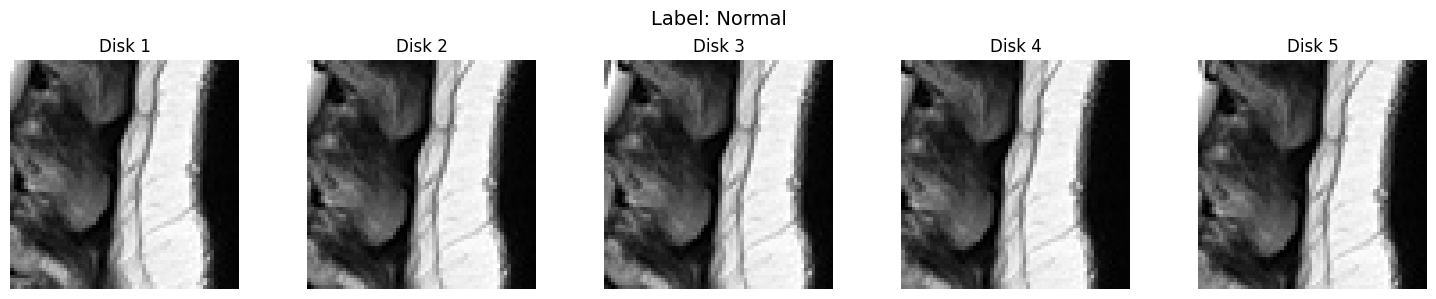

In [13]:
import matplotlib.pyplot as plt
from dataset import DiskCropDataset
from torchvision import transforms

# 전처리 정의 (선택)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Dataset 생성
dataset = DiskCropDataset(
    image_dir="./data/processed_lsd_jpgs_renamed",
    coord_csv_path="./mydata/coords_processed.csv",
    transform=transform,
    crop_size=64  # 혹은 96 등 조정 가능
)

# 샘플 1개 추출
crops, label = dataset[0]  # crops: torch.Size([5, 1, 64, 64])

# 시각화
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(crops[i][0], cmap="gray")
    plt.title(f"Disk {i+1}")
    plt.axis("off")

plt.suptitle(f"Label: {'Abnormal' if label == 1 else 'Normal'}", fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
from PIL import Image
img = Image.open('./data/processed_lsd_jpgs_renamed/21449862.jpg')
print(img.size)  # (width, height)

(256, 256)


c:\dlproject\dlvenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46356 (\N{HANGUL SYLLABLE DI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\dlproject\dlvenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\dlproject\dlvenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\dlproject\dlvenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\dlproject\dlvenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\dlproject\dl

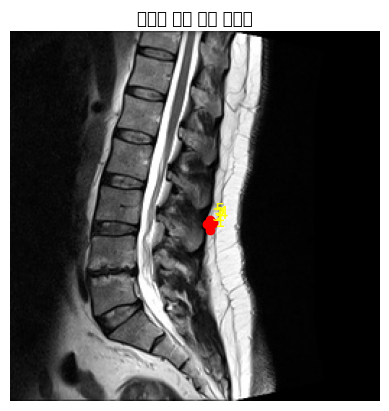

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# 좌표 로딩
df = pd.read_csv("./mydata/coords_processed.csv")
img_path = "./data/processed_lsd_jpgs_renamed/" + df.iloc[0]["filename"]

# 이미지 로딩
img = Image.open(img_path)
plt.imshow(img, cmap='gray')

# 중심 좌표 시각화
for i in range(1, 6):
    x = df.iloc[0][f"x{i}"]
    y = df.iloc[0][f"y{i}"]
    plt.scatter(x, y, c='red')
    plt.text(x + 3, y - 3, f"{i}", color='yellow', fontsize=12)

plt.title("디스크 중심 좌표 시각화")
plt.axis("off")
plt.show()


In [ ]:
# 1. CSV 로딩
df = pd.read_csv("./coords_rsna_improved.csv")

print(df.groupby("series_id")["level"].count().value_counts())
# print(df['level'])

level
10    5430
5      307
6      201
4      137
8       82
2       42
3       40
1       20
9       17
7       14
15       1
Name: count, dtype: int64
0        L1/L2
1        L1/L2
2        L2/L3
3        L2/L3
4        L3/L4
         ...  
58730    L3/L4
58731    L4/L5
58732    L4/L5
58733    L5/S1
58734    L5/S1
Name: level, Length: 58735, dtype: object


In [18]:
group = df[df["series_id"] == 21449862]
print(group[["level", "x", "y"]])

KeyError: "['x', 'y'] not in index"

In [21]:
import pandas as pd

# 1. CSV 로딩
df = pd.read_csv("./coords_rsna_improved.csv")

# 2. 상대좌표 → 절대좌표 변환
IMG_SIZE = 256
df["x"] = (df["relative_x"] * IMG_SIZE).astype(int)
df["y"] = (df["relative_y"] * IMG_SIZE).astype(int)

# 3. 디스크 레벨 순서 정의 및 정렬
level_order = ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']
df = df[df["level"].isin(level_order)].copy()
df["level"] = pd.Categorical(df["level"], categories=level_order, ordered=True)
df = df.sort_values(by=["series_id", "side", "level"])

# 4. 'series_id + side' 조합에서 level이 5개인 경우만 필터링
valid_groups = df.groupby(["series_id", "side"]).filter(lambda x: len(x) == 5)

# 5. wide-format으로 변환 (디스크 5개 좌표 → 열로 변환)
coords_df = valid_groups.groupby(["series_id", "side"]).apply(
    lambda x: pd.Series({
        "x1": x.iloc[0]["x"], "y1": x.iloc[0]["y"],
        "x2": x.iloc[1]["x"], "y2": x.iloc[1]["y"],
        "x3": x.iloc[2]["x"], "y3": x.iloc[2]["y"],
        "x4": x.iloc[3]["x"], "y4": x.iloc[3]["y"],
        "x5": x.iloc[4]["x"], "y5": x.iloc[4]["y"]
    })
).reset_index()

# 6. 이미지 파일명 및 라벨 추가
coords_df["filename"] = coords_df["series_id"].astype(str) + ".jpg"
coords_df["label"] = 0  # 기본값은 정상(0), 필요시 이후 수정

# 7. 저장
coords_df.to_csv("./mydata/coords_processed.csv", index=False)

print(f"최종 샘플 수: {len(coords_df)}")
print(coords_df.head())

최종 샘플 수: 8206
   series_id side   x1  y1   x2   y2   x3   y3   x4   y4   x5   y5  \
0      10996    L  133  83  126  102  124  121  124  141  125  159   
1      10996    R  132  81  129   98  125  119  124  143  123  160   
2     370109    L  100  67   94  102   87  136   86  172  100  204   
3     370109    R  144  72  139  105  135  137  138  162  142  187   
4    2142829    L   81  77   72  117   74  160   82  197   95  229   

      filename  label  
0    10996.jpg      0  
1    10996.jpg      0  
2   370109.jpg      0  
3   370109.jpg      0  
4  2142829.jpg      0  


C:\Users\human-12\AppData\Local\Temp\ipykernel_6864\1824512438.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  coords_df = valid_groups.groupby(["series_id", "side"]).apply(


In [27]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# 경로
IMG_DIR = "./data/processed_lsd_jpgs"

# 시각화할 샘플 선택
sample = coords_df.iloc[0]

# '10996.jpg' → '0001.jpg' 형태로 파일명 보정
original_filename = sample["filename"]
num_part = os.path.splitext(str(original_filename))[0]  # '10996'
filename = num_part.zfill(4) + ".jpg"  # → '0001.jpg' 형식으로 보정
image_path = os.path.join(IMG_DIR, filename)

# 이미지 불러오기
print(f"Trying to load: {image_path}")
image = Image.open(image_path).convert("L")

# 디스크 좌표 추출
coords = [(sample[f"x{i}"], sample[f"y{i}"]) for i in range(1, 6)]
crop_size = 64

# 시각화
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i, (x, y) in enumerate(coords):
    left = int(x - crop_size // 2)
    upper = int(y - crop_size // 2)
    right = left + crop_size
    lower = upper + crop_size
    crop = image.crop((left, upper, right, lower))

    axes[i].imshow(crop, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"Disk {i+1}")

plt.suptitle(f"Filename: {filename}", fontsize=14)
plt.tight_layout()
plt.show()

Trying to load: ./data/processed_lsd_jpgs\10996.jpg


FileNotFoundError: [Errno 2] No such file or directory: './data/processed_lsd_jpgs\\10996.jpg'

In [28]:
df_pretrain = pd.read_csv('./coords_pretrain.csv')

print(df_pretrain.head())

   filename  source    x    y  level  relative_x  relative_y
0  1_t2.jpg  spider  139  175  L5/S1    0.542969    0.683594
1  1_t2.jpg  spider  133  157  L4/L5    0.519531    0.613281
2  1_t2.jpg  spider  132  131  L3/L4    0.515625    0.511719
3  1_t2.jpg  spider  131  102  L2/L3    0.511719    0.398438
4  1_t2.jpg  spider  134   84  L1/L2    0.523438    0.328125


In [32]:
print(df_pretrain.groupby('source')[['source', 'filename']].head(1))

      source       filename
0     spider       1_t2.jpg
1045     lsd       0001.jpg
3565    tseg  case_0000.jpg
5440     osf       ID02.jpg


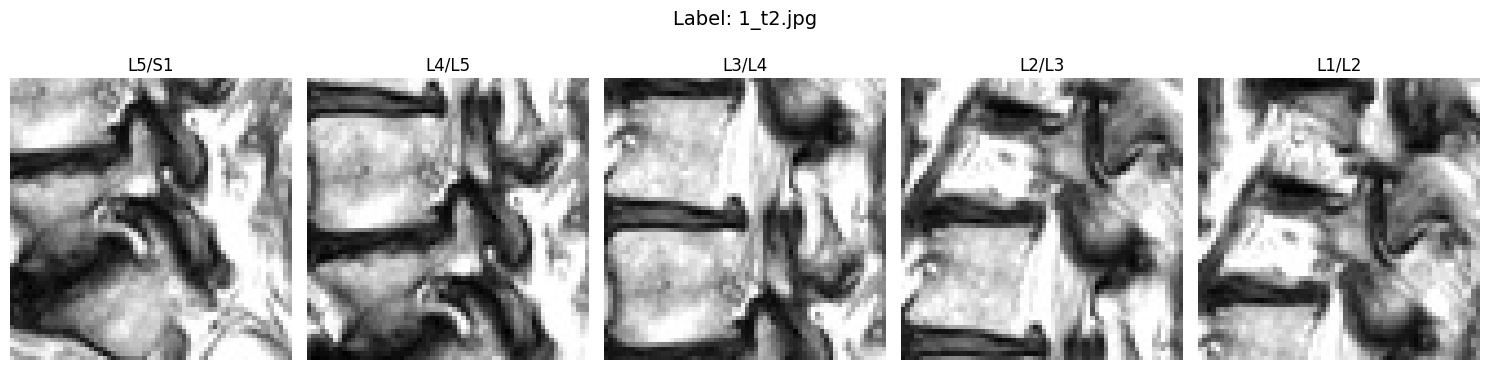

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# -----------------------
# 1. 데이터 로딩
# -----------------------
df_pretrain = pd.read_csv("./coords_pretrain.csv")

# -----------------------
# 2. 시각화할 샘플 선택
# -----------------------
sample = df_pretrain[df_pretrain['filename'] == "1_t2.jpg"]

# 이미지 경로 구성
source = sample['source'].iloc[0]  # 예: 'spider'
filename = sample['filename'].iloc[0]
img_path = f"./data/processed_{source}_jpgs/{filename}"

# 이미지 열기
image = Image.open(img_path).convert("L")
image = image.resize((256, 256))  # 좌표가 상대좌표면 resize 고정 필요

# -----------------------
# 3. 디스크 영역 crop 및 시각화
# -----------------------
fig, axes = plt.subplots(1, len(sample), figsize=(15, 4))
fig.suptitle(f"Label: {filename}", fontsize=14)

for i, (_, row) in enumerate(sample.iterrows()):
    x, y = int(row['relative_x'] * 256), int(row['relative_y'] * 256)
    crop = image.crop((x - 32, y - 32, x + 32, y + 32))

    axes[i].imshow(crop, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"{row['level']}")

plt.tight_layout()
plt.show()

### crop한 이미지들 저장하기

In [41]:
import pandas as pd
import os
import cv2

# 좌표 CSV 로드
coord_df = pd.read_csv('coords_pretrain.csv')

# base 경로
base_dir = 'data'
crop_dir = 'crops'
os.makedirs(crop_dir, exist_ok=True)

crop_size = 64

for i, row in coord_df.iterrows():
    filename = row['filename']       # 예: 1_t2.jpg
    source = row['source']           # 예: spider, lsd 등
    x, y = int(row['x']), int(row['y'])
    level = row['level']             # 예: L4/L5

    # source → 폴더 이름 변환
    image_subdir = f'processed_{source}_jpgs'
    img_path = os.path.join(base_dir, image_subdir, filename)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"[경고] 이미지 없음: {img_path}")
        continue

    h, w = img.shape
    if not (crop_size//2 <= x <= w - crop_size//2 and crop_size//2 <= y <= h - crop_size//2):
        print(f"[경고] 경계 밖 crop: {filename} ({x},{y}) / 이미지 크기: {w}x{h}")
        continue

    crop = img[y - crop_size//2:y + crop_size//2, x - crop_size//2:x + crop_size//2]
    if crop.shape != (crop_size, crop_size):
        print(f"[경고] 잘못된 crop 크기: {filename} → {crop.shape}")
        continue
    
    level_safe = level.replace('/', '_')
    save_name = f"{filename.replace('.jpg','')}_{level_safe}.jpg"
    save_path = os.path.join(crop_dir, save_name)

    success = cv2.imwrite(save_path, crop)
    if success:
        print(f"[저장 완료] {save_path}")
    else:
        print(f"[실패] 저장 오류: {save_path}")

[저장 완료] crops\1_t2_L5_S1.jpg
[저장 완료] crops\1_t2_L4_L5.jpg
[저장 완료] crops\1_t2_L3_L4.jpg
[저장 완료] crops\1_t2_L2_L3.jpg
[저장 완료] crops\1_t2_L1_L2.jpg
[저장 완료] crops\2_t2_L5_S1.jpg
[저장 완료] crops\2_t2_L4_L5.jpg
[저장 완료] crops\2_t2_L3_L4.jpg
[저장 완료] crops\2_t2_L2_L3.jpg
[저장 완료] crops\2_t2_L1_L2.jpg
[저장 완료] crops\3_t2_L5_S1.jpg
[저장 완료] crops\3_t2_L4_L5.jpg
[저장 완료] crops\3_t2_L3_L4.jpg
[저장 완료] crops\3_t2_L2_L3.jpg
[저장 완료] crops\3_t2_L1_L2.jpg
[저장 완료] crops\4_t2_L5_S1.jpg
[저장 완료] crops\4_t2_L4_L5.jpg
[저장 완료] crops\4_t2_L3_L4.jpg
[저장 완료] crops\4_t2_L2_L3.jpg
[저장 완료] crops\4_t2_L1_L2.jpg
[저장 완료] crops\5_t2_L5_S1.jpg
[저장 완료] crops\5_t2_L4_L5.jpg
[저장 완료] crops\5_t2_L3_L4.jpg
[저장 완료] crops\5_t2_L2_L3.jpg
[저장 완료] crops\5_t2_L1_L2.jpg
[저장 완료] crops\6_t2_L5_S1.jpg
[저장 완료] crops\6_t2_L4_L5.jpg
[저장 완료] crops\6_t2_L3_L4.jpg
[저장 완료] crops\6_t2_L2_L3.jpg
[저장 완료] crops\6_t2_L1_L2.jpg
[저장 완료] crops\7_t2_L5_S1.jpg
[저장 완료] crops\7_t2_L4_L5.jpg
[저장 완료] crops\7_t2_L3_L4.jpg
[저장 완료] crops\7_t2_L2_L3.jpg
[저장 완료] crops\

In [39]:
print(os.path.abspath(crop_dir))

c:\dlproject\crops


In [34]:
import pandas as pd

# CSV 불러오기
df = pd.read_csv('coords_rsna_improved.csv')

# crop 이미지 이름 생성: study_id_level.jpg
df['filename'] = df['study_id'].astype(str) + '_' + df['level'] + '.jpg'

# is_abnormal: 병변 정보가 있으면 1, 아니면 0
df['is_abnormal'] = df['condition'].notnull().astype(int)

# 중복 제거: 하나의 level당 하나의 라벨만 (예: Left/Right 둘 다 있으면 1개만)
df = df[['filename', 'is_abnormal']].drop_duplicates(subset='filename')

# 저장
df.to_csv('train_labels.csv', index=False)

print(df.head())

               filename  is_abnormal
0  3996069892_L1/L2.jpg            1
2  3996069892_L2/L3.jpg            1
4  3996069892_L3/L4.jpg            1
6  3996069892_L4/L5.jpg            1
8  3996069892_L5/S1.jpg            1
